In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.metrics import accuracy_score, roc_auc_score,recall_score,make_scorer
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPClassifier


# стороняя библиотека для работы с несбалансированными датасетами
# pip install imblearn
from imblearn.over_sampling import SMOTE, ADASYN

# настройки отображения графиков
# %config InlineBackend.figure_format = 'svg' 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
%matplotlib inline

# увеличим  размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8,7

from tqdm import tqdm_notebook

# для воспроизводимости
r_state = 11

In [3]:
data_path = './data/creditcard.csv'

In [4]:
df = pd.read_csv(data_path)

Проверим, что все считалось должным образом:

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Сперва посмотрим на распределение меток у целевого класса:

In [6]:
# sns.countplot(df['Class']);

Оценим, насколько мошеннические транзакции коррелируют со временем:

In [7]:
# sns.distplot(df[df['Class']==1]['Time'],100);

Как видим, распределение числа мошеннических транзакций во времени имеет примерно равномерный характер, следовательно, можно исключить из выборки этот признак. Тем более, что это время отсчитывалось, начиная от первой транзакции, следовательно, оно не имеет ценности

Посмотрим как пространство признаков изображается при двумерной проекции(на примере признаков 'V11', 'V12', 'V13', 'V14', 'V15') :

In [8]:
# %%time

# rcParams['figure.figsize'] = 12,12
# sns_plot = sns.pairplot(df,vars=['V11', 'V12', 'V13', 'V14', 'V15'],hue="Class",markers=["o", "s"])
# rcParams['figure.figsize'] = 8,7

Для получения качественных оценок работы алгоритма, я буду сравнивать такие метрики как:
- **Recall score**

   Это оценка вида: 
   
   $$score = {tp \over tp + fn}$$
   
   tp - число предсказаний, когда модель верно обнаружила нужные транзакции.
   
   fn - число предсказаний, когда модель не распознала поддельный перевод.
   
   Чем ближе это значение к 1, тем меньше модель пропускает поддельных транзакций. Но, возможно, она будет помечать некоторые переводы как поддельные, хотя они таковыми не являются. Следующие метрики должны помочь проконтролировать этот аспект.
   
   
- **Accuracy**

   Доля верных ответов, будем его тоже учитывать.
   
   
- **ROC AUC score**

   Площадь, ограниченная ROC-кривой и осью доли ложных положительных классификаций.
   Эта метрика позволяет судить о качестве бинарной классификации и в совокупности с Recall score должна дать нам наглядное представление о работе классификатора.

In [9]:
# df = df.sample(n=50000,random_state = r_state)

С помощью этой функции будем выводить информацию обо всех метриках для данной выборки и классификатора:

Для того, что получить сбалансированный датасет, я буду использовать алгоритм ADASYN(Adaptive Synthetic Sampling),поскольку SMOTE (Synthetic Minority Over-sampling Technique) создает больше примеров внутри кластера, а ADASYN создает больше синтетических примеров на границе. 

В случае, когда данные генерируются ADASYN, модель становится более "подозрительной", поскольку будет лучше опознавать мошеннические транзакции на границе двух кластеров, ведь ADASYN может расширить границы имеющего кластера. Хотя это и может привести к ошибкам рода False Positive, мне кажется, что такой подход будет надежнее и более подходит для предотвращения мошенничества.

Производить оценку метрик я буду на трех датасетах.

1. На исходном
2. На тестовой части датасета.
3. На датасете, полученным контатенацией равных долей поддельных транзакций и неподдельных. То есть, я соединил все поддельные транзакции с тем же числом неподдельных. Это нужно, чтобы посмотреть на оценки в случае, когда число поддельных и неподдельных транзакций сбалансированно и данные оригинальные, в таком случае они более точны, поскольку у модели нет возможности предсказывать, допустим только "0" и при этом показывать хорошие результаты. (функция ниже)

In [10]:
# Соединим строки поддельных с переводов исходного датасета с таким же количеством неподдельных
def create_balanced_data_from_initial(data):
    
    fraud = data[(data['Class']==1)]
    not_fraud = data[(data['Class']==0)]
    
    n_fraud = len(fraud)//2
    

    X_original_unb = pd.concat([fraud[n_fraud:].drop(['Class','Time'], axis=1)
                                    ,not_fraud[n_fraud:].drop(['Class','Time'], axis=1)])
    
    y_original_unb = pd.concat([fraud[n_fraud:]['Class']
                                    ,not_fraud[n_fraud:]['Class']])
    
    
    X_original_b = pd.concat([fraud[:n_fraud-1].drop(['Class','Time'], axis=1)
                                 ,not_fraud[:n_fraud-1].drop(['Class','Time'], axis=1)])
    
    y_original_b = pd.concat([fraud[:n_fraud-1]['Class']
                                 ,not_fraud[:n_fraud-1]['Class']])
    

    return X_original_unb,y_original_unb,X_original_b,y_original_b
    

In [11]:
# Применение алгоритма ADASYN
def create_balanced_data_adasyn(x,y):
    sm = ADASYN(random_state=12, ratio = 0.4)
    X,Y = sm.fit_sample(x, y)
    X = pd.DataFrame(X,columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'] )
    Y = pd.DataFrame(Y,columns = ['Class'])
    return X,Y

In [12]:
def all_metrics_validation(clf,X,Y_true):
    print("Accuracy score: "+ str(accuracy_score(Y_true,clf.predict(X))))
    
    print("ROC AUC score: "+ str(roc_auc_score(Y_true,clf.predict_proba(X)[:,1])))
    # нас интересуют положительные результаты
    print("Recall score: "+ str(recall_score(Y_true,clf.predict(X))))
    
    print("Precicion score: "+ str(precision_score(Y_true,clf.predict(X))))

In [13]:
# Оценка модели на указанных датасетах
def estimate_model(clf, X_original_b,y_original_b,  X_test, y_test):

    print('\nМетрики на тестовой части :\n')
    all_metrics_validation(clf,X_test, y_test)
    
    print('\nМетрики на небольшой сбалансированой части,составленной из элементов оригинального датасета:\n')
    all_metrics_validation(clf,X_original_b,y_original_b)
    

In [14]:
X_original_unb,y_original_unb,X_original_b,y_original_b = create_balanced_data_from_initial(df)

In [15]:
y_original_unb.value_counts()

0    284069
1       246
Name: Class, dtype: int64

In [16]:
y_original_b.value_counts()

1    245
0    245
Name: Class, dtype: int64

In [17]:
# Разделим на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(X_original_unb,y_original_unb, test_size=0.3)

Далее, при генерации данных ADASYN, необходимо сначала отделить тестовую и проверочную выборки, а затем для тренировочной сгенерировать новые данные. Тк в противном случае, если сначала создать новых данных, а потом разделить выборку, то синтетические данные попадут в проверочный сет.

In [18]:
X_train_adasyn, y_train_adasyn = create_balanced_data_adasyn(X_train, y_train)

/home/ilyua/ml/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


KeyboardInterrupt: 

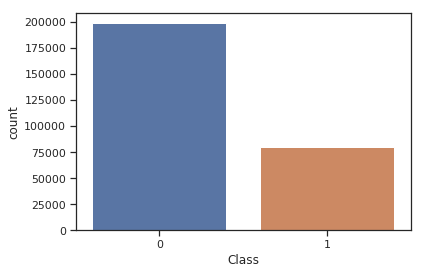

In [19]:
sns.countplot(y_train_adasyn['Class']);y_train_adasyn['Class'].value_counts()

StratifiedKFold - сохраняет процент образцов в тестовом и тренировочных сетах, поэтому такому кросс-валиждатору можно доверять

# Случайный лес

In [ ]:
%%time
parameters = {'max_features': ['auto'], 'min_samples_leaf': range(5,30,2),'max_depth': range(3,30,3),'n_estimators':range(40,500,20),'n_jobs':[-1]}

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=r_state)

rfc = RandomForestClassifier()

gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=2,scoring='recall')

gcv.fit(X_train_adasyn, y_train_adasyn)

In [ ]:
clf = gcv.best_estimator_
gcv.best_params_ , gcv.best_score_

In [ ]:
estimate_model(clf, X_original_b,y_original_b, X_test, y_test)

# Метод ближайших соседей

In [ ]:
%%time
parameters = {'n_neighbors': range(30,100,10),'n_jobs':[-1]}

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=r_state)

knn = KNeighborsClassifier()

gcv = GridSearchCV(knn, parameters, n_jobs=-1, cv=skf, verbose=2,scoring='recall')

gcv.fit(X_train_adasyn, y_train_adasyn)

In [ ]:
clf = gcv.best_estimator_
gcv.best_params_ , gcv.best_score_

In [ ]:
estimate_model(clf, X_original_b,y_original_b,  X_test, y_test)

# Логистическая регрессия

In [ ]:
%%time
logit = LogisticRegression(n_jobs=-1)       

parameters = {'C': np.linspace(20,70,70),}

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=r_state)

gcv = GridSearchCV(logit, parameters, n_jobs=-1, cv=skf, verbose=1,scoring='recall')

gcv.fit(X_train_adasyn, y_train_adasyn)

In [ ]:
clf = gcv.best_estimator_
gcv.best_params_ , gcv.best_score_

In [ ]:
estimate_model(clf, X_original_b,y_original_b,  X_test, y_test)

Нейросеть

Поскольку перед нами не стоит задача распознавания изображений, у нас не так много данных и они не имею слишком большой размерности, то воспользуемся встроенной в SKlearn нейросетью - MultiLayerClassifier

In [ ]:
%%time

scaler = StandardScaler() 
scaler.fit_transform(X_train_adasyn)


mlp = MLPClassifier(random_state=r_state)
parameters = {'activation':['logistic'], 'alpha':[1e-5],'hidden_layer_sizes':[(20,),(30,),(50,),(60,),(200,)],'learning_rate':['adaptive']}

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=r_state)

gcv = GridSearchCV(mlp, parameters, n_jobs=-1, cv=skf, verbose=1,scoring='recall')

gcv.fit(X_train_adasyn, y_train_adasyn)

In [ ]:
clf = gcv.best_estimator_
gcv.best_params_ , gcv.best_score_

In [ ]:
estimate_model(clf, scaler.transform(X_original_b),y_original_b, scaler.transform(X_test),y_test)